In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import joblib


from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler


from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

from kerastuner import HyperModel, HyperParameters, RandomSearch
from tensorflow import keras


from tensorflow.keras import layers
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [3]:
from google.colab import files

uploaded = files.upload()


Saving Financial_Distress.csv to Financial_Distress.csv


In [4]:
import io
data = io.BytesIO(uploaded['Financial_Distress.csv'])

In [5]:
df = pd.read_csv(data)
df.head()

,ID,Company Name,Year,Sector,Financial Distress,Shareholder Concentration (%),Independence Indicator,CEO Duality,Board of Directors Size,Director Remuneration (£million),Corporate Borrowing,Company Age,Retained Earnings / Total Assets (£),Interest Paid / Total Assets (£)
0,1,1SPATIAL PLC,2022,Business Services,0,79.63,6,1,36,0.687,0,18,0.005040,0.005951
1,2,1SPATIAL PLC,2021,Business Services,0,79.63,6,1,36,0.714,0,18,-0.030734,0.006174
2,3,1SPATIAL PLC,2020,Business Services,0,79.63,6,1,36,0.521,0,18,-0.043072,0.006816
3,4,1SPATIAL PLC,2019,Business Services,0,79.63,6,1,36,0.564,0,18,-0.077413,0.009062
4,5,1SPATIAL PLC,2018,Business Services,0,79.63,6,1,36,0.670,0,18,-0.129682,0.009866


In [6]:
df.columns

Index(['ID', 'Company Name', 'Year', 'Sector', 'Financial Distress',
       'Shareholder Concentration (%)', 'Independence Indicator',
       'CEO Duality', 'Board of Directors Size',
       'Director Remuneration (£million)', 'Corporate Borrowing',
       'Company Age', 'Retained Earnings / Total Assets (£)',
       'Interest Paid / Total Assets (£)'],
      dtype='object')

In [7]:
#rename columns
df.rename(columns = {'Company Name':'company_name', 'Financial Distress':'financial_distress','Shareholder Concentration (%)':'shareholder_concentration', 'Independence Indicator':'independence_indicator', 'CEO Duality':'CEO_duality', 'Board of Directors Size':'board_of_directors_size',
                     'Director Remuneration (£million)':'director_renumeration', 'Corporate Borrowing':'corporate_borrowing', 'Company Age':'company_age',
                     'Retained Earnings / Total Assets (£)':'retained_earnings', 'Interest Paid / Total Assets (£)':'interest_paid'}, inplace = True)

In [8]:
df.shape

(2792, 14)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2792 entries, 0 to 2791
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         2792 non-null   int64  
 1   company_name               2792 non-null   object 
 2   Year                       2792 non-null   int64  
 3   Sector                     2792 non-null   object 
 4   financial_distress         2792 non-null   int64  
 5   shareholder_concentration  2792 non-null   float64
 6   independence_indicator     2792 non-null   int64  
 7   CEO_duality                2792 non-null   int64  
 8   board_of_directors_size    2792 non-null   int64  
 9   director_renumeration      2792 non-null   float64
 10  corporate_borrowing        2792 non-null   int64  
 11  company_age                2792 non-null   int64  
 12  retained_earnings          2792 non-null   float64
 13  interest_paid              2792 non-null   float

In [10]:
df.describe()

,ID,Year,financial_distress,shareholder_concentration,independence_indicator,CEO_duality,board_of_directors_size,director_renumeration,corporate_borrowing,company_age,retained_earnings,interest_paid
count,2792.0000,2792.000000,2792.000000,2792.000000,2792.000000,2792.000000,2792.000000,2792.000000,2792.000000,2792.00000,2792.000000,2792.000000
mean,1396.5000,2018.500000,0.233166,45.152951,7.309456,0.518625,33.773639,3.287621,0.393625,43.21490,-0.013462,0.014155
std,806.1253,2.291698,0.422923,24.205378,1.599515,0.499743,14.649481,4.458202,0.488641,33.23904,0.210046,0.037038
min,1.0000,2015.000000,0.000000,0.000000,1.000000,0.000000,6.000000,0.000465,0.000000,9.00000,-3.869245,0.000015
25%,698.7500,2016.750000,0.000000,24.690000,8.000000,0.000000,23.000000,0.799750,0.000000,20.00000,-0.022273,0.004158
50%,1396.5000,2018.500000,0.000000,45.810000,8.000000,1.000000,31.000000,1.822000,0.000000,28.00000,0.020300,0.008755
75%,2094.2500,2020.250000,0.000000,63.320000,8.000000,1.000000,42.000000,3.851750,1.000000,58.00000,0.050194,0.014772
max,2792.0000,2022.000000,1.000000,97.890000,8.000000,1.000000,91.000000,53.358000,1.000000,139.00000,1.655414,1.411748


In [11]:
df.isna().sum().sum()

0

In [12]:
# check for duplicates
df.duplicated().value_counts()

False    2792
dtype: int64

summary: there are no duplicates, no missing values in the dataset
    
dataset has 2792 rows and 14 columns

8 columns as integers

4 columns as float

and 2 columns as objects

In [13]:
#encode sector column

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Sector' column

df['sector'] = label_encoder.fit_transform(df['Sector'])
df = df.drop(['Sector'], axis = 1)

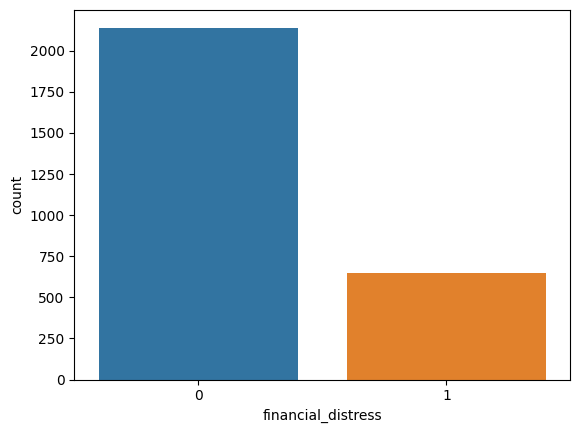

In [14]:
# countplot of the target variable
sns.countplot(x = df['financial_distress']);

This shows that the target variable is imbalanced and it would restrict the models from learning patterns well from the other class. Hence, a good solution to this would be Oversampling of the minority class to enable the trained model make better predictions.

In [15]:
df['sector'].value_counts()

2     592
6     240
12    240
3     192
24    168
8     160
5     152
21    144
17    112
20     96
11     88
7      80
15     64
1      64
16     56
4      56
14     48
22     40
19     32
10     32
9      32
0      24
13     24
18     24
25     24
23      8
Name: sector, dtype: int64

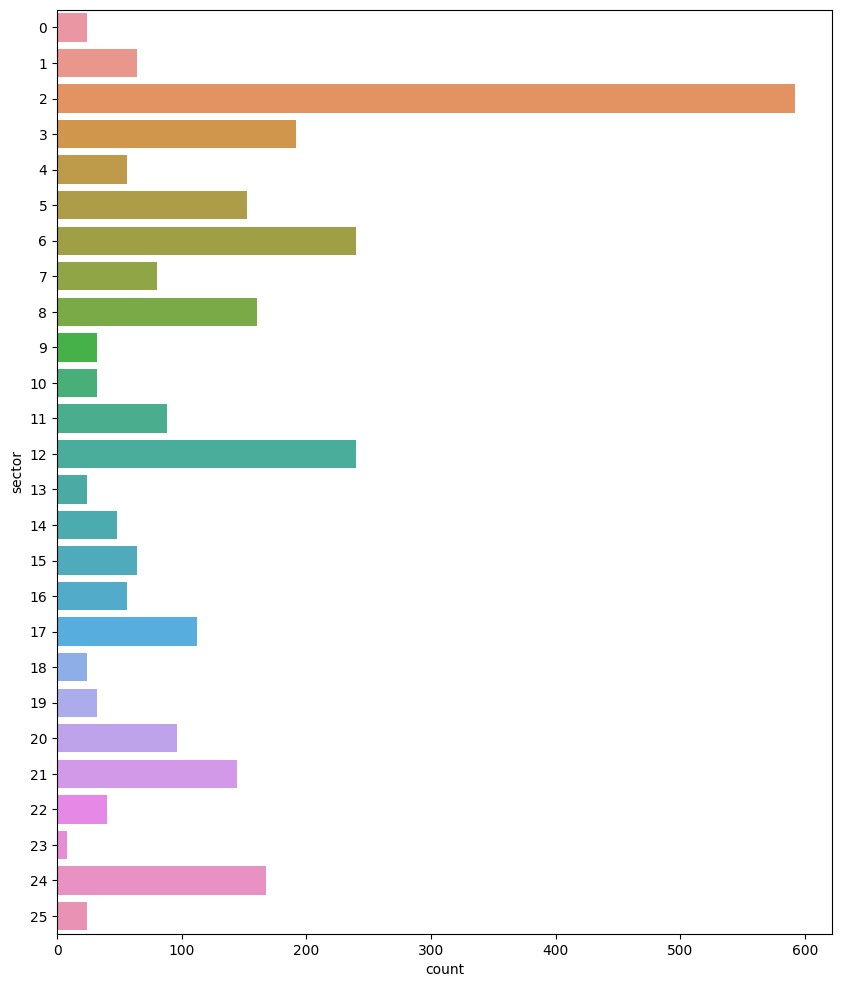

In [16]:
plt.figure(figsize = (10,12))
sns.countplot(y = df['sector']);

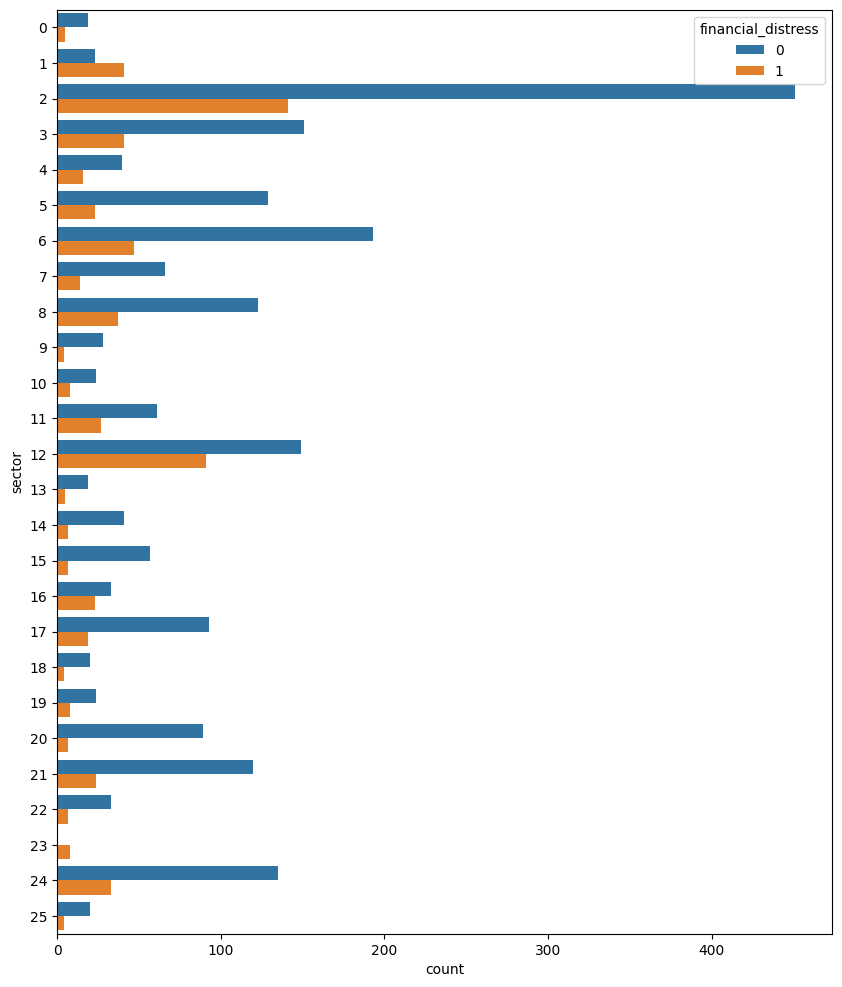

In [17]:
plt.figure(figsize = (10,12))
sns.countplot(y = df['sector'], hue = df['financial_distress']);

In [18]:
#group the df by Sector and Year and find the count
grouped_counts_df = df.groupby(['sector'])['Year'].value_counts().unstack()

#add a column for sector totals
grouped_counts_df['Total'] = grouped_counts_df.sum(axis=1)

#create and display a dataframe showing company count in each year and in total, sorted by the total
grouped_counts_df = pd.DataFrame(grouped_counts_df).sort_values(by='Total', ascending=False).style.format('{:.0f}')
display(grouped_counts_df)

Year,2015,2016,2017,2018,2019,2020,2021,2022,Total
sector,,,,,,,,,
2,74,74,74,74,74,74,74,74,592
12,30,30,30,30,30,30,30,30,240
6,30,30,30,30,30,30,30,30,240
3,24,24,24,24,24,24,24,24,192
24,21,21,21,21,21,21,21,21,168
8,20,20,20,20,20,20,20,20,160
5,19,19,19,19,19,19,19,19,152
21,18,18,18,18,18,18,18,18,144
17,14,14,14,14,14,14,14,14,112


## DATA PREPROCESSING AND FEATURE TRANSFORMATION

To avoid repetition of codes, Functions will be created for the visualizations of the distribution  across the columns in the dataset

In [19]:

def plot_dist_plots(dataframe):
    num_cols = len(dataframe.columns)
    num_rows = (num_cols // 4) + 1

    fig = plt.figure(figsize=(18, 12))
    fig.suptitle("Distribution Plots", fontsize='x-large', weight='extra bold', ha='center')

    for i, column in enumerate(dataframe.columns):
        plt.subplot(num_rows, 4, i+1)
        sns.distplot(dataframe[column], color='green')

    plt.tight_layout()
    plt.show()

def plot_box_plots(dataframe):
    num_cols = len(dataframe.columns)
    num_rows = (num_cols // 4) + 1

    fig = plt.figure(figsize=(18, 12))
    fig.suptitle("Box Plots", fontsize='x-large', weight='extra bold', ha='center')

    for i, column in enumerate(dataframe.columns):
        plt.subplot(num_rows, 4, i+1)
        sns.boxplot(dataframe[column], color='red')

    plt.tight_layout()
    plt.show()


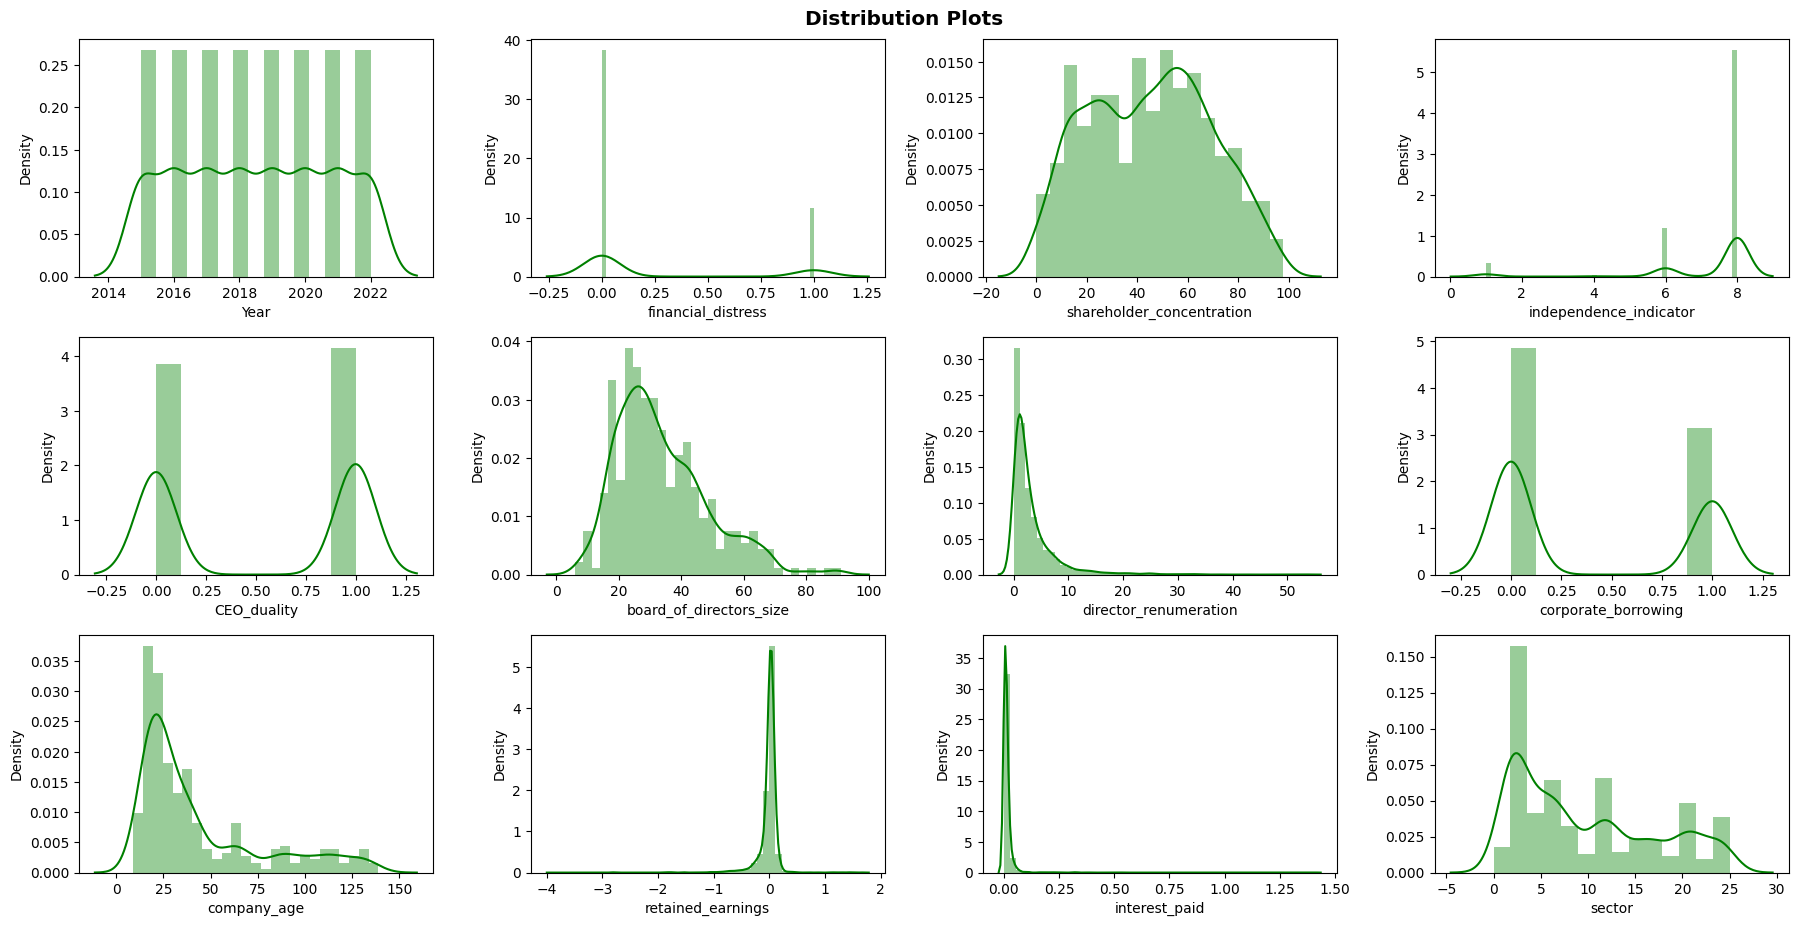

In [20]:
df_dist = df.drop(['company_name', 'ID'], axis = 1)
plot_dist_plots(df_dist)

log_transformation will be performed on the right_skewed columns and square root transformation will be performed on the left_skewed columns.

In [21]:

right_skewed_columns = ['independence_indicator', 'retained_earnings']
left_skewed_columns = ['board_of_directors_size', 'director_renumeration', 'company_age', 'interest_paid']

right_skewed_data = df[right_skewed_columns]
left_skewed_data = df[left_skewed_columns]

log_transform = FunctionTransformer(func=np.log1p)
log_transformed_data = log_transform.fit_transform(right_skewed_data)

sqrt_transformed_data = np.sqrt(left_skewed_data)


# Convert the scaled arrays back to dataframes
log_data = pd.DataFrame(log_transformed_data, columns=right_skewed_columns)
sqrt_data = pd.DataFrame(sqrt_transformed_data, columns=left_skewed_columns)


In [22]:

old_columns = ['ID','company_name', 'sector', 'Year', 'financial_distress', 'shareholder_concentration', 'CEO_duality', 'corporate_borrowing']

# Combine the transformed and non-transformed DataFrames
df = pd.concat([df[old_columns], log_data, sqrt_data], axis=1)


In [23]:
df.head()

,ID,company_name,sector,Year,financial_distress,shareholder_concentration,CEO_duality,corporate_borrowing,independence_indicator,retained_earnings,board_of_directors_size,director_renumeration,company_age,interest_paid
0,1,1SPATIAL PLC,2,2022,0,79.63,1,0,1.94591,0.005027,6.0,0.828855,4.242641,0.077145
1,2,1SPATIAL PLC,2,2021,0,79.63,1,0,1.94591,-0.031216,6.0,0.844985,4.242641,0.078575
2,3,1SPATIAL PLC,2,2020,0,79.63,1,0,1.94591,-0.044027,6.0,0.721803,4.242641,0.082560
3,4,1SPATIAL PLC,2,2019,0,79.63,1,0,1.94591,-0.080574,6.0,0.750999,4.242641,0.095194
4,5,1SPATIAL PLC,2,2018,0,79.63,1,0,1.94591,-0.138897,6.0,0.818535,4.242641,0.099328


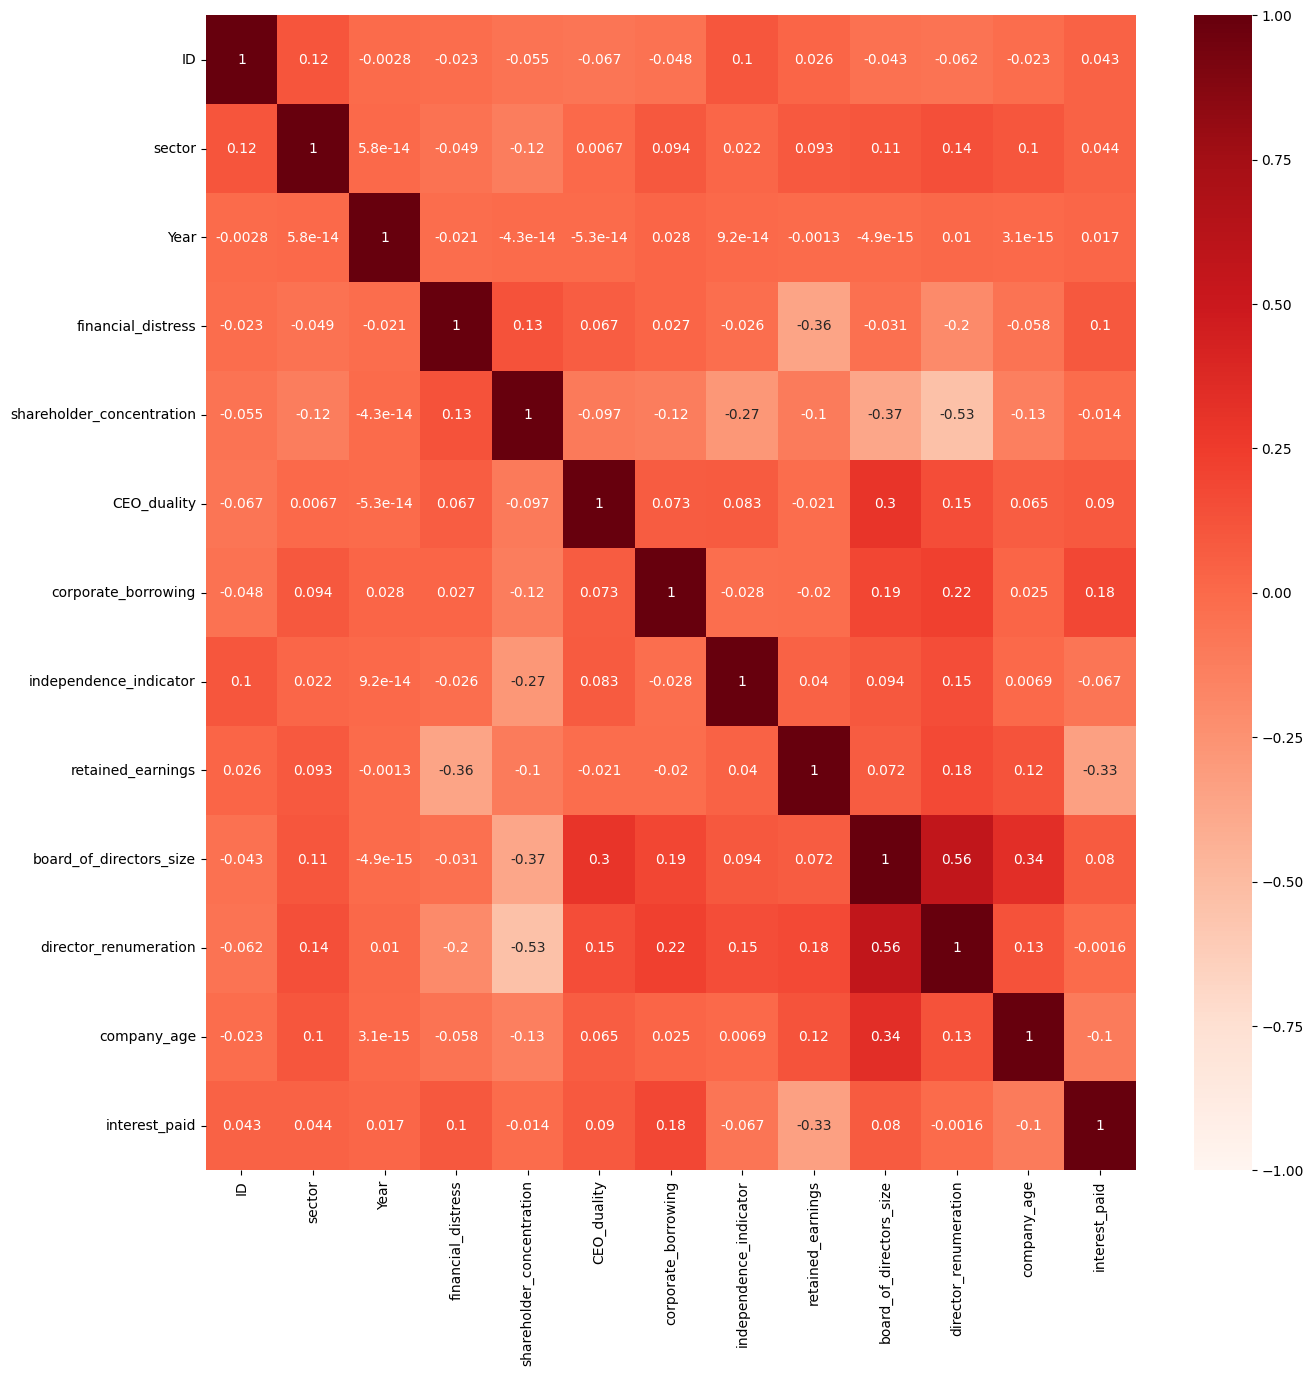

In [24]:
corr = df.corr()
ax, fig = plt.subplots(figsize=(15,15))
sns.heatmap(corr, vmin=-1, cmap='Reds', annot=True)
plt.show();

data is split into input and target variables before preprocessing to avoid data leakage when training machine learning model

In [25]:
#drop columns
df = df.drop(['company_name', 'ID', 'Year'], axis = 1)


In [26]:
df.isna().sum()

sector                        0
financial_distress            0
shareholder_concentration     0
CEO_duality                   0
corporate_borrowing           0
independence_indicator        0
retained_earnings            18
board_of_directors_size       0
director_renumeration         0
company_age                   0
interest_paid                 0
dtype: int64

after transforming the data, there were some missing values which will be filled with the mean value

In [27]:
df['retained_earnings'].mean()

-0.018203993885363364

In [28]:
df['retained_earnings'] = df['retained_earnings'].fillna(df['retained_earnings'].mean())

In [29]:
df.isna().sum()

sector                       0
financial_distress           0
shareholder_concentration    0
CEO_duality                  0
corporate_borrowing          0
independence_indicator       0
retained_earnings            0
board_of_directors_size      0
director_renumeration        0
company_age                  0
interest_paid                0
dtype: int64

In [30]:
#split data into input and target variables
x = df.drop('financial_distress', axis=1)
y = df['financial_distress']

Addressing the class imbalance by oversampling

In [31]:
#Oversampling of the minority class in the target column

oversample = RandomOverSampler(sampling_strategy='not majority')
x_sampled, y_sampled = oversample.fit_resample(x, y)

x = x_sampled
y = y_sampled


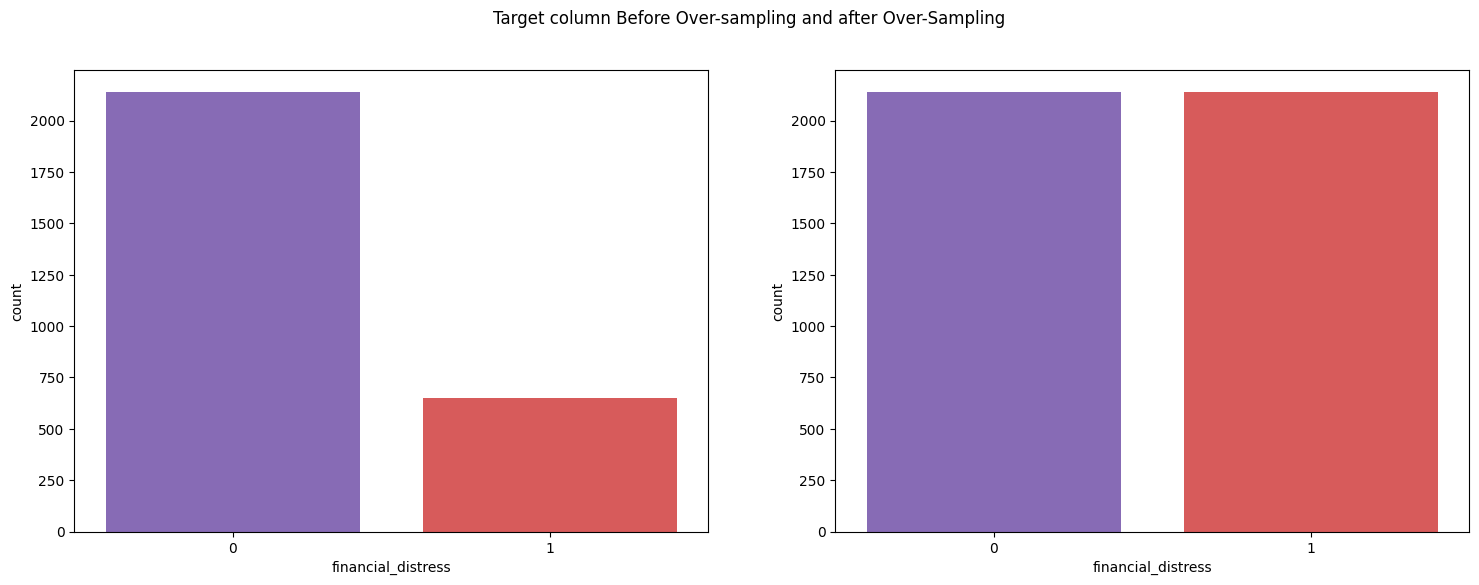

In [32]:
#visualize the oversampling results
plt.figure(figsize=(18,6))
plt.suptitle('Target column Before Over-sampling and after Over-Sampling')
plt.subplot(1,2,1)
sns.countplot(x = df['financial_distress'], palette=['#845ec2','#ec4646','#00af91'])
plt.subplot(1,2,2)
sns.countplot(data=pd.DataFrame(y),x = 'financial_distress', palette=['#845ec2','#ec4646','#00af91'] )
plt.show()

In [33]:
#split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [34]:
x_train.head()

,sector,shareholder_concentration,CEO_duality,corporate_borrowing,independence_indicator,retained_earnings,board_of_directors_size,director_renumeration,company_age,interest_paid
378,2,59.57,1,1,2.197225,-0.000107,7.211103,1.544021,6.000000,0.115345
3345,2,18.39,0,0,2.197225,-0.510013,4.795832,0.927901,4.242641,0.019368
678,8,48.31,0,0,2.197225,0.009670,6.082763,1.488959,6.082763,0.098575
3946,4,79.40,0,0,2.197225,-0.024847,5.000000,1.081203,5.196152,0.105232
1515,15,38.17,0,0,2.197225,0.005940,5.291503,1.463557,4.358899,0.112097


In [35]:
y_train.head()

378     0
3345    1
678     0
3946    1
1515    0
Name: financial_distress, dtype: int64

## MODEL TRAINING

MODELS TRAINED



*  LOGISTIC REGRESSION
*   RANDOM FOREST CLASSIFIER

*   SUPPORT VECTOR MACHINES
*   1-D CONVOLUTIONAL NEURAL NETWORK





### Model 1: Logistic Regression

In [36]:
#create an instance for the model
log_reg = LogisticRegression()
#fit model to training data
log_reg.fit(x_train, y_train)
log_reg_pred = log_reg.predict(x_test)
print(confusion_matrix(y_test, log_reg_pred))

[[532 129]
 [213 411]]


In [37]:
print(classification_report(y_test,log_reg_pred))

              precision    recall  f1-score   support

           0       0.71      0.80      0.76       661
           1       0.76      0.66      0.71       624

    accuracy                           0.73      1285
   macro avg       0.74      0.73      0.73      1285
weighted avg       0.74      0.73      0.73      1285



### Model 2: Random Forest Classifier

In [38]:
#create an instance for the model
rfc_model = RandomForestClassifier()
#fit model to training data
rfc_model.fit(x_train, y_train)
#predict
rfc_pred = rfc_model.predict(x_test)

print(confusion_matrix(y_test, rfc_pred))

[[566  95]
 [ 28 596]]


In [39]:
print(classification_report(y_test, rfc_pred))


              precision    recall  f1-score   support

           0       0.95      0.86      0.90       661
           1       0.86      0.96      0.91       624

    accuracy                           0.90      1285
   macro avg       0.91      0.91      0.90      1285
weighted avg       0.91      0.90      0.90      1285



### Model 4: Convolutional Neural Network

In [42]:

# Subtract 1 from the labels to align with zero-based indices
y_train_encoded = y_train - 1
y_test_encoded = y_test - 1

# Convert target labels to one-hot encoded format
y_train_encoded = to_categorical(y_train_encoded, num_classes=2)
y_test_encoded = to_categorical(y_test_encoded, num_classes=2)


In [43]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(10, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 50)                12850     
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 13,144
Trainable params: 13,144
Non-trainable params: 0
____________________________________________________

In [44]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(x_train,y_train_encoded, batch_size= 2, epochs= 10, verbose=1, validation_split = 0.3)

Epoch 1/10
1049/1049 [==============================] - 5s 3ms/step - loss: 0.7212 - accuracy: 0.5637 - val_loss: 0.6433 - val_accuracy: 0.6267
Epoch 2/10
1049/1049 [==============================] - 3s 3ms/step - loss: 0.6328 - accuracy: 0.6371 - val_loss: 0.5892 - val_accuracy: 0.7022
Epoch 3/10
1049/1049 [==============================] - 3s 3ms/step - loss: 0.5886 - accuracy: 0.6800 - val_loss: 0.6212 - val_accuracy: 0.6489
Epoch 4/10
1049/1049 [==============================] - 4s 4ms/step - loss: 0.5685 - accuracy: 0.7067 - val_loss: 0.5800 - val_accuracy: 0.6978
Epoch 5/10
1049/1049 [==============================] - 3s 3ms/step - loss: 0.5538 - accuracy: 0.7086 - val_loss: 0.5936 - val_accuracy: 0.7033
Epoch 6/10
1049/1049 [==============================] - 3s 3ms/step - loss: 0.5497 - accuracy: 0.7258 - val_loss: 0.5590 - val_accuracy: 0.7244
Epoch 7/10
1049/1049 [==============================] - 3s 3ms/step - loss: 0.5507 - accuracy: 0.7277 - val_loss: 0.5713 - val_accuracy:

In [45]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

41/41 [==============================] - 0s 2ms/step - loss: 0.5712 - accuracy: 0.6996
Test Loss: 0.5711570382118225
Test Accuracy: 0.6996108889579773


In [46]:

def plot_graph(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Adjust spacing between plots
    plt.tight_layout()

    # Show the plot
    plt.show()


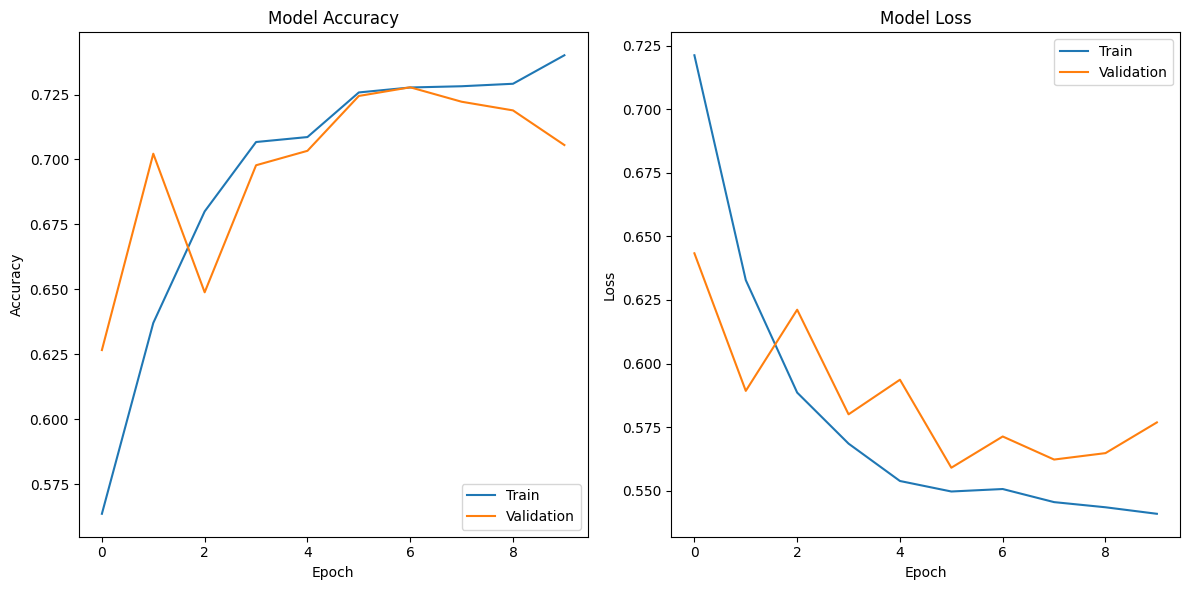

In [47]:
plot_graph(history)

## MODEL IMPROVEMENT AND OPTIMIZATION

LOGISTIC REGRESSION

In [61]:
# Grid search cross validation

param_grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg,param_grid = param_grid,cv=5)
grid_search.fit(x_train,y_train)

# Print the best hyperparameters and corresponding performance metric
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'C': 10.0, 'penalty': 'l2'}
Best Score:  0.7213795214245965


In [62]:
# Train the final model with the best hyperparameters on the entire training data
log_reg_tuned = LogisticRegression(**grid_search.best_params_)
log_reg_tuned.fit(x_train, y_train)

#predict
log_reg_tuned_pred = log_reg_tuned.predict(x_test)

# Calculate and print the confusion matrix
print(confusion_matrix(y_test, log_reg_tuned_pred))

[[540 121]
 [208 416]]


In [63]:
print(classification_report(y_test, log_reg_tuned_pred))

              precision    recall  f1-score   support

           0       0.72      0.82      0.77       661
           1       0.77      0.67      0.72       624

    accuracy                           0.74      1285
   macro avg       0.75      0.74      0.74      1285
weighted avg       0.75      0.74      0.74      1285



In [66]:
# Evaluate the final model on the test data
log_reg_accuracy = log_reg_tuned.score(x_test, y_test)
print("Test Accuracy after Tuning: ", log_reg_accuracy)

Test Accuracy after Tuning:  0.7439688715953308


RANDOM FOREST

In [48]:

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [3, 6, 12],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
}

# Create a random forest classifier
rf_classifier = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and corresponding performance metric
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}
Best Score:  0.8778820255982194


In [52]:
# Train the final model with the best hyperparameters on the entire training data
rf_tuned = RandomForestClassifier(**grid_search.best_params_)
rf_tuned.fit(x_train, y_train)

#predict
rf_tuned_pred = rf_tuned.predict(x_test)

# Calculate and print the confusion matrix
print(confusion_matrix(y_test, rf_tuned_pred))

[[567  94]
 [ 27 597]]


In [53]:
print(classification_report(y_test, rf_tuned_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       661
           1       0.86      0.96      0.91       624

    accuracy                           0.91      1285
   macro avg       0.91      0.91      0.91      1285
weighted avg       0.91      0.91      0.91      1285



In [54]:
# Evaluate the tuned model on the test data
rf_accuracy = rf_tuned.score(x_test, y_test)
print("Test Accuracy after Tuning: ", rf_accuracy)

Test Accuracy after Tuning:  0.9058365758754864


CONVOLUTIONAL NEURAL NETWORK

In [57]:

#define model architecture
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                            kernel_size=hp.Int('kernel_size', min_value=3, max_value=5),
                            activation='relu',
                            input_shape=(10, 1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

#state hyperparameters to tune
hp = HyperParameters()
hp.Int('filters', min_value=32, max_value=128, step=32)
hp.Int('kernel_size', min_value=3, max_value=5)
hp.Int('units', min_value=32, max_value=128, step=32)

#Define model-building function
class MyHyperModel(HyperModel):
    def build(self, hp):
        return build_model(hp)

#Define search space
hypermodel = MyHyperModel()

#Configure the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='my_project'
)

#Search for the best hyperparameters
tuner.search(x_train, y_train_encoded, epochs=10, validation_split=0.3)

#get best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

#Train a model with the best hyperparameters gotten
best_model = tuner.hypermodel.build(best_hyperparameters)
best_model_history = best_model.fit(x_train, y_train_encoded, epochs=10, validation_split=0.3)


Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.6866666674613953

Best val_accuracy So Far: 0.7122222185134888
Total elapsed time: 00h 00m 49s
Epoch 1/10
66/66 [==============================] - 2s 13ms/step - loss: 0.8150 - accuracy: 0.5274 - val_loss: 0.6593 - val_accuracy: 0.5978
Epoch 2/10
66/66 [==============================] - 1s 8ms/step - loss: 0.6377 - accuracy: 0.6128 - val_loss: 0.6520 - val_accuracy: 0.6256
Epoch 3/10
66/66 [==============================] - 1s 8ms/step - loss: 0.6098 - accuracy: 0.6714 - val_loss: 0.5899 - val_accuracy: 0.6911
Epoch 4/10
66/66 [==============================] - 0s 5ms/step - loss: 0.5877 - accuracy: 0.6862 - val_loss: 0.6119 - val_accuracy: 0.6744
Epoch 5/10
66/66 [==============================] - 0s 5ms/step - loss: 0.5896 - accuracy: 0.6810 - val_loss: 0.5920 - val_accuracy: 0.6889
Epoch 6/10
66/66 [==============================] - 0s 5ms/step - loss: 0.5924 - accuracy: 0.6881 - val_loss: 0.6113 - val_accuracy: 0.6767
Epoch 7/10
66/66

In [58]:
# Evaluate trained model on the test data
cnn_loss, cnn_accuracy = best_model.evaluate(x_test, y_test_encoded)
print("Test Loss:", cnn_loss)
print("Test Accuracy:", cnn_accuracy)

41/41 [==============================] - 0s 2ms/step - loss: 0.6591 - accuracy: 0.6584
Test Loss: 0.6591318845748901
Test Accuracy: 0.658365786075592


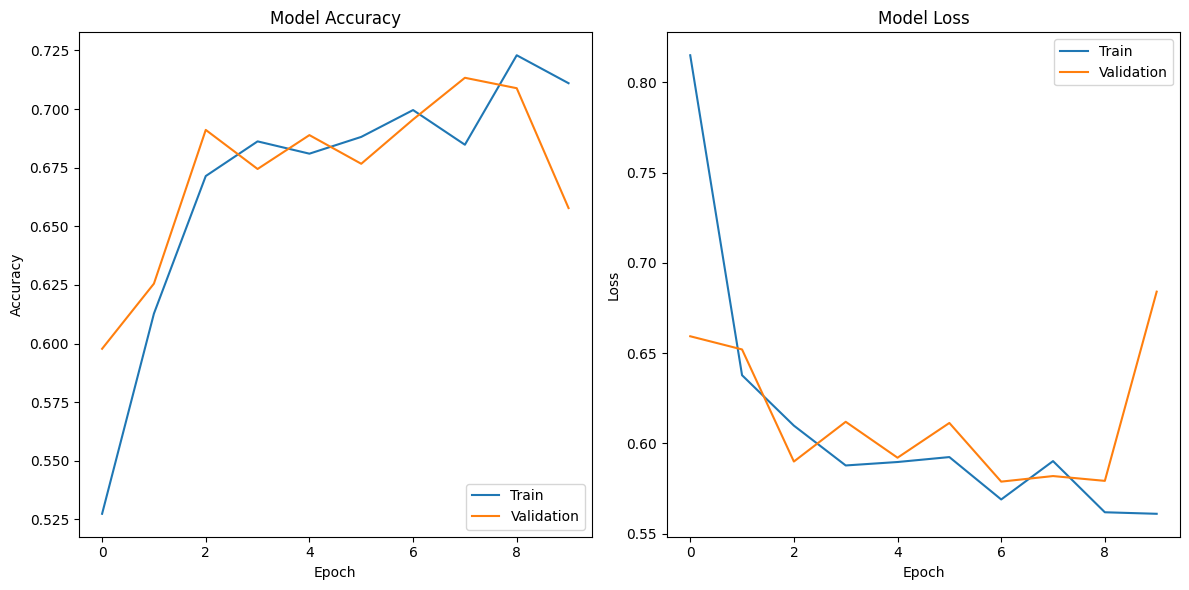

In [59]:
plot_graph(best_model_history)

OVERALL MODEL METRICS AFTER TUNING OF HYPER PARAMETERS

In [67]:
#create a dictionary for the models and accuracies
model_df = {
    'Model': [
    'Logistic Regression',
    'Random Forest Classifier',
    '1-D Convolutional Neural Network',
    ],

    'Accuracy(%)': [
        f"{log_reg_accuracy*100:.2f}",
        f"{rf_accuracy*100:.2f}",
        f"{cnn_accuracy*100:.2f}",
        ]
}


#create a dataframe from the dictionary
evaluation_metrics = pd.DataFrame(model_df)

evaluation_metrics



,Model,Accuracy(%)
0,Logistic Regression,74.40
1,Random Forest Classifier,90.58
2,1-D Convolutional Neural Network,65.84


In [68]:
# Convert the 'Accuracy(%)' column to float
evaluation_metrics['Accuracy(%)'] = evaluation_metrics['Accuracy(%)'].astype(float)

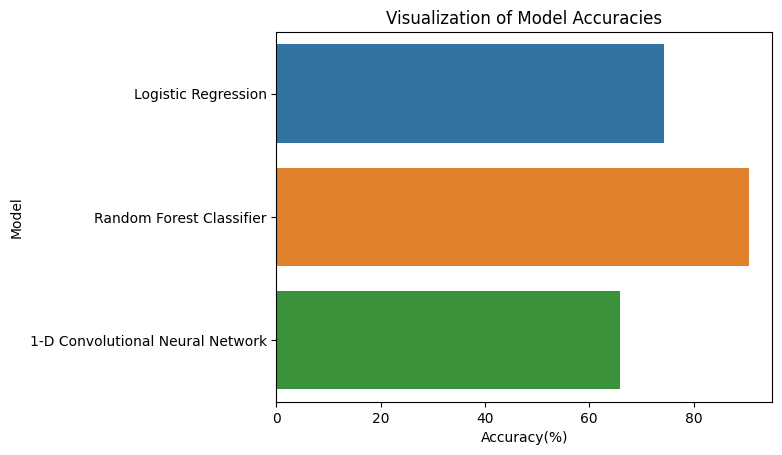

In [69]:
# Plot the model accuracies using a bar plot
sns.barplot(x='Accuracy(%)', y='Model', data=evaluation_metrics)

# Add labels and title
plt.xlabel('Accuracy(%)')
plt.ylabel('Model')
plt.title('Visualization of Model Accuracies')

# Show the plot
plt.show()

In [70]:
import pickle

#save model
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_classifier, f)


In [74]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the saved model from Google Drive
with open("/content/drive/My Drive/random_forest_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
